## Dataset from kaggle
https://www.kaggle.com/datasets/andrewmvd/leukemia-classification

Original dataset
https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=52758223

Gupta, A., & Gupta, R. (2019). ALL Challenge dataset of ISBI 2019 [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/tcia.2019.dc64i46r

In [ ]:
# import needed libraries

import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from leukemic_det.params import *
from google.cloud import storage
from tqdm import tqdm


2023-03-23 09:04:45.731915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1) Load Data


In [3]:
# create a client to the GCS bucket

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)


In [4]:
# setting files paths

blob_p = "C-NMC_Leukemia/training_data/fold_"

all_0 = bucket.blob(f"{blob_p}0/all")
all_1 = bucket.blob(f"{blob_p}1/all")
all_2 = bucket.blob(f"{blob_p}2/all")

hem_0 = bucket.blob(f"{blob_p}0/hem")
hem_1 = bucket.blob(f"{blob_p}1/hem")
hem_2 = bucket.blob(f"{blob_p}2/hem")


In [5]:
def get_path_image(folder):
    image_paths = []
    for blob in bucket.list_blobs(prefix=folder.name):
        image_path = blob.name
        image_paths.append(image_path)
    return image_paths


In [6]:
# load training data paths

img_data = []

for i in [all_0,all_1,all_2,hem_0,hem_1,hem_2]:
    paths = get_path_image(i)

    img_data.extend(paths)

print(len(img_data))


10661


In [7]:
data_train = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data_train_df = pd.DataFrame(data_train)
data_train_df


,img_data,labels
0,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
1,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
2,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
3,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
4,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
...,...,...
10656,C-NMC_Leukemia/training_data/fold_2/hem/UID_h3...,NaN
10657,C-NMC_Leukemia/training_data/fold_2/hem/UID_h3...,NaN
10658,C-NMC_Leukemia/training_data/fold_2/hem/UID_h3...,NaN
10659,C-NMC_Leukemia/training_data/fold_2/hem/UID_h3...,NaN


In [8]:
data_train_df.loc[0:7272, 'labels'] = 1 # ALL
data_train_df.loc[7272:, 'labels'] = 0 # HEM


In [9]:
data_train_df['labels'].value_counts()


1.0    7272
0.0    3389
Name: labels, dtype: int64

In [10]:
data_train_df.head()


,img_data,labels
0,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0
1,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0
2,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0
3,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0
4,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0


In [11]:
# shuffle the data

data_train_df = data_train_df.sample(frac=1).reset_index(drop=True)


In [12]:
data_train_df.head()


,img_data,labels
0,C-NMC_Leukemia/training_data/fold_1/hem/UID_H2...,0.0
1,C-NMC_Leukemia/training_data/fold_2/hem/UID_H1...,0.0
2,C-NMC_Leukemia/training_data/fold_2/all/UID_47...,1.0
3,C-NMC_Leukemia/training_data/fold_1/hem/UID_H1...,0.0
4,C-NMC_Leukemia/training_data/fold_0/all/UID_52...,1.0


In [13]:
z = data_train_df.iloc[:7272, :]
z['labels'].value_counts()


1.0    4983
0.0    2289
Name: labels, dtype: int64

In [14]:
# create a sample df just to test the workflow

sample_df = data_train_df.iloc[1000:2000, :]
sample_df.reset_index(inplace=True, drop=True)
sample_df.head()


,img_data,labels
0,C-NMC_Leukemia/training_data/fold_2/all/UID_67...,1.0
1,C-NMC_Leukemia/training_data/fold_0/all/UID_35...,1.0
2,C-NMC_Leukemia/training_data/fold_1/all/UID_51...,1.0
3,C-NMC_Leukemia/training_data/fold_0/all/UID_45...,1.0
4,C-NMC_Leukemia/training_data/fold_1/all/UID_51...,1.0


In [15]:
sample_df['labels'].value_counts()


1.0    676
0.0    324
Name: labels, dtype: int64

In [16]:
sample_img_list = []

for i in tqdm(range(len(sample_df))):

    blob = bucket.blob(sample_df['img_data'][i])
    image_bytes = blob.download_as_bytes()
    nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv.imdecode(nparr, cv.IMREAD_COLOR)
    sample_img_list.append(image)


100%|██████████| 1000/1000 [08:11<00:00,  2.04it/s]


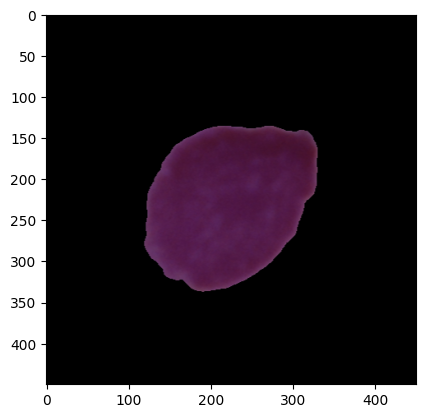

In [17]:
plt.imshow(sample_img_list[99])
plt.show()


In [18]:
X = np.array(sample_img_list)
y = np.array(sample_df['labels'])


In [19]:
X.shape


(1000, 450, 450, 3)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


In [21]:
y_df = pd.DataFrame(y_val)


In [22]:
y_df.value_counts()


1.0    138
0.0     62
dtype: int64

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


(800, 450, 450, 3)
(800,)
(200, 450, 450, 3)
(200,)


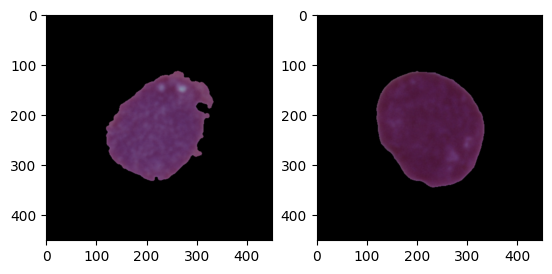

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[9]);
plt.subplot(1, 2, 2)
plt.imshow(X_val[8]);


In [25]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import models, layers


In [26]:
def load_model():

  model = models.Sequential()

  model.add(Rescaling(1./450, input_shape=(450,450,3)))

  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(16, (2, 2), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())

  model.add(layers.Dense(10))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


In [27]:
base_model = load_model()


2023-03-23 09:13:28.550369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
base_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 450, 450, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 450, 450, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 225, 225, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 225, 225, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 225, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                    

In [29]:
from tensorflow.keras.callbacks import EarlyStopping


In [32]:
es_base = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)


In [ ]:
base_history = base_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                              batch_size=128, callbacks=[es_base], epochs=25)


In [34]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)


In [ ]:
plot_history(base_history)


In [ ]:
save_model_path = '/trained_models/cnn_base_model_simple'
load_model_path = '/trained_models/cnn_base_model_simple/saved_model.pb'
keras.models.save_model(base_model, save_model_path)
model_filename = 'cnn_base_model_simple'

blob = bucket.blob(f"models/{model_filename}")
blob.upload_from_filename(load_model_path)


In [37]:
# load test data

test_folder = bucket.blob("C-NMC_Leukemia/testing_data/C-NMC_test_prelim_phase_data")
test_image_paths = []
for blob in bucket.list_blobs(prefix=test_folder.name):
    image_path = blob.name
    test_image_paths.append(image_path)

print(len(test_image_paths))


1868


In [38]:
test_img_list = []

for i in tqdm(range(100)):
    blob = bucket.blob(test_image_paths[i])
    image_bytes = blob.download_as_bytes()
    nparr = np.frombuffer(image_bytes, np.uint8)
    test_img = cv.imdecode(nparr, cv.IMREAD_COLOR)
    test_img_list.append(test_img)


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


In [39]:
X_test= []
for i in test_img_list:
    s = np.resize((i), (450, 450, 3))
    X_test.append(s)
X_test = np.array(X_test)


In [40]:
len(test_img_list)


100

In [41]:
X_test.shape


(100, 450, 450, 3)

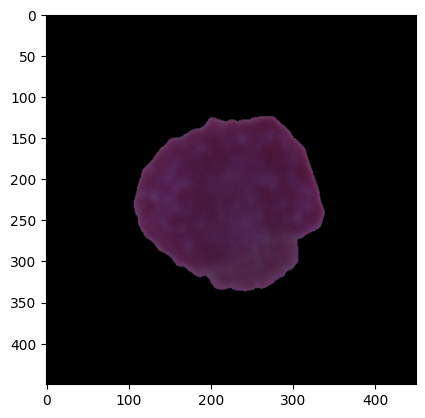

In [42]:
plt.imshow(test_img_list[19])
plt.show()


In [46]:
labels = bucket.blob("C-NMC_Leukemia/testing_data/C-NMC_test_prelim_phase_data_labels.csv")
csv_data = labels.download_to_filename('test_labels')

# Create a Pandas DataFrame from the CSV data
test_img_labels = pd.read_csv('test_labels')
test_img_labels.head()


,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [44]:
y_test = np.array(test_img_labels['labels'])
y_test = y_test[:100]


In [ ]:
score = base_model.evaluate(X_test, y_test)[1]


In [ ]:
print(f"The accuracy of the baseline model is: {score}")


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers

def load_VGG16_model():

    VGG_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    VGG_model.trainable=False

    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(10, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        VGG_model,
        flattening_layer,
        dense_layer,
        prediction_layer
        ])


    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(loss='binary_crossentropy', optimizer= opt, metrics='accuracy')

    return model


In [ ]:
model_VGG16 = load_VGG16_model()


In [ ]:
model_VGG16.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 14, 14, 512)       14714688  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 10)                1003530   
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 15,718,229
Trainable params: 1,003,541
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input


In [ ]:
X_train_vg = preprocess_input(X_train)
X_val_vg = preprocess_input(X_val)
X_test_vg = preprocess_input(X_test)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=10)


In [ ]:
history = model_VGG16.fit(X_train_vg, y_train, validation_data=(X_val_vg, y_val),
                          callbacks=[es], batch_size=64, epochs=50)


In [ ]:
score_vg = model_VGG16.evaluate(X_test_vg, y_test)[1]


In [ ]:
print(f"The accuracy of the model is: {score}")
